# Defining soft constraints


In [58]:
import matplotlib.pyplot as plt
import math

import numpy as np
import pandas as pd
import reframed
import os
import json
import sys 
sys.path.append("../functions/")

import translation_dicts
import general_functions as general_func

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
compounds_dict, source_dict,substrate_dict, gas_sheet_dict, community_dict = translation_dicts.translation_dicts()

### Read data and models

**Read data**

In [61]:
all_Mags_for_paper_analysis = general_func.read_allmags_data()

**Load models made without soft constraints**

In [62]:
directory = os 

directory = os.fsencode("../output/GEMs/GEMs_no_constraints/")

GEMs_dict = {}
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    if filename.endswith(".xml"): 
        print(filename)
        GEMs_dict[filename[:-4]]= reframed.load_cbmodel("../output/GEMs/GEMs_no_constraints/"+filename)
        continue
    else:
        continue

CH7-bin.18.xml
CH15-bin.7.xml
CH13-bin.0.xml
CH1-bin.4.xml
CH13-bin.1.xml
CH13-bin.11.xml
CH15-bin.6.xml
CH7-bin.2.xml
CH13-bin.13.xml
CH1-bin.10.xml
CH1-bin.6.xml
CH13-bin.2.xml
CH13-bin.12.xml
CH15-bin.5.xml
CH7-bin.1.xml
CH15-bin.1.xml
CH1-bin.3.xml
CH13-bin.17.xml
CH15-bin.0.xml
CH7-bin.4.xml
CH7-bin.23.xml
CH7-bin.6.xml
CH15-bin.22.xml
CH15-bin.2.xml
CH1-bin.1.xml
CH13-bin.4.xml
CH13-bin.14.xml
CH15-bin.23.xml
CH7-bin.20.xml
CH8-bin.8.xml
CH8-bin.9.xml
CH8-bin.25.xml
CH14-bin.4.xml
CH14-bin.1.xml
CH8-bin.21.xml
CH14-bin.2.xml
CH8-bin.22.xml
CH8-bin.2.xml
CH8-bin.29.xml
CH8-bin.7.xml
CH8-bin.6.xml
CH3-bin.2.xml
CH8-bin.14.xml
CH8-bin.16.xml
CH3-bin.0.xml
CH8-bin.5.xml
CH3-bin.1.xml
CH8-bin.17.xml
CH7-bin.11.xml
CH9-bin.1.xml
CH15-bin.12.xml
CH13-bin.25.xml
CH15-bin.13.xml
CH9-bin.0.xml
CH7-bin.12.xml
CH9-bin.2.xml
CH7-bin.9.xml
CH15-bin.10.xml
CH7-bin.8.xml
CH7-bin.13.xml
CH7-bin.17.xml
CH15-bin.8.xml
CH15-bin.15.xml
CH7-bin.16.xml
CH9-bin.6.xml
CH9-bin.4.xml
CH15-bin.17.xml
CH1-bi

In [63]:
with open("../output/relevant_MAGs_99.txt") as text_file:
    relevant_MAGs = text_file.read().split("\n")

relevant_MAGs = [string.replace("\t","") for string in relevant_MAGs]


In [64]:
with open("../output/community_production.json") as text_file:
    community_production = json.load(text_file)

In [65]:
with open("../output/community_production_names.json") as text_file:
    community_production_names = json.load(text_file)

In [66]:
with open("../output/compounds_dict_list.json") as text_file: 
    compounds_dict_list = json.load(text_file)

In [67]:
with open("../output/compounds_dict.json") as text_file: 
    compounds_dict = json.load(text_file)

In [68]:
MAG2community_id = pd.read_csv("../output/MAG2community_id.tsv",sep="\t",header=None,index_col=0)

# Defining soft constraints (vol. 2)

- **Excluding elements that can already be produced by a community member in complete media**
    - Choose complete media - because production could be triggered by metabolites produced by another community members, which we do not know of.
- **Focus on 99% most abundant species**

### Find the producers (from the 99% most abundant species)

**Get 99% most abundant species (>1%)**

In [69]:
## Find the community they belong to
MAG2community_id_most_abundant = MAG2community_id[MAG2community_id.index.isin(relevant_MAGs)]
enrich_groups_top = MAG2community_id_most_abundant.groupby(1).groups# top 99

In [70]:
## Find producers in COMPLETE media and growth=0

# For each community set the default production to False
comm_producers_top = {community_id:{MAG:{compound:False for compound in compounds.keys()} for MAG in enrich_groups_top[community_id]} for community_id,compounds in community_production_names.items()}
for community_id,MAGs in enrich_groups_top.items():
    for MAG in MAGs:
        print(MAG)
        model = GEMs_dict[MAG].copy()
        
        complete_env = reframed.Environment.from_model(model)      
        
        for compound in community_production_names[community_id].keys():
            mets = compounds_dict_list[compound]

            ex_rxns = ["R_EX_"+met+"_e" for met in mets if "R_EX_"+met+"_e" in model.get_exchange_reactions()]
            
            if len(ex_rxns)==0:
                continue
            
            sol = reframed.FVA(model,constraints=complete_env,reactions=ex_rxns)
            print(sol)
            total_prod = sum([value[1] for value in sol.values()])
            comm_producers_top[community_id][MAG][compound] = total_prod>1e-6

CH13-bin.12
{'R_EX_ac_e': [0.0, 348.8897817061737]}
{'R_EX_ppa_e': [0.0, 331.71534575307857]}
{'R_EX_co2_e': [-3.0177514792899407, 938.477492115072]}
CH13-bin.11
{'R_EX_ac_e': [-10.0, 1019.0893470790377]}
{'R_EX_ppa_e': [0.0, 898.3671586715868]}
{'R_EX_but_e': [0.0, 10.0]}
{'R_EX_lac__L_e': [-10.0, 1095.8125157708807]}
{'R_EX_ppoh_e': [-10.0, -0.0]}
{'R_EX_h2_e': [-10.0, -0.0]}
{'R_EX_co2_e': [-10.0, 1393.3675464320622]}
CH13-bin.4
{'R_EX_ac_e': [-10.0, 1280.425974025974]}
{'R_EX_etoh_e': [-0.10786615490746598, -0.0]}
{'R_EX_ppa_e': [0.0, 1566.309523809524]}
{'R_EX_but_e': [0.0, 20.0]}
{'R_EX_co2_e': [-10.0, 1492.6923076923085]}
CH13-bin.14
{'R_EX_ac_e': [-10.0, 1747.5000000000005]}
{'R_EX_ppa_e': [-10.0, -0.0]}
{'R_EX_but_e': [0.0, 1747.4999999999998]}
{'R_EX_lac__L_e': [-10.0, 1640.7777777777776]}
{'R_EX_3mb_e': [-10.0, -0.0]}
{'R_EX_co2_e': [-10.0, 3864.4139194139198]}
CH13-bin.25
{'R_EX_ac_e': [0.0, 910.4687500000001]}
{'R_EX_etoh_e': [-10.0, 2259.145226811104]}
{'R_EX_ppa_e': [-10

#### Plotting production

In [71]:
dfs_community_count_top = {community_id:pd.DataFrame(producers_dict).sum(axis=1).rename("top99%") for community_id,producers_dict in comm_producers_top.items()}

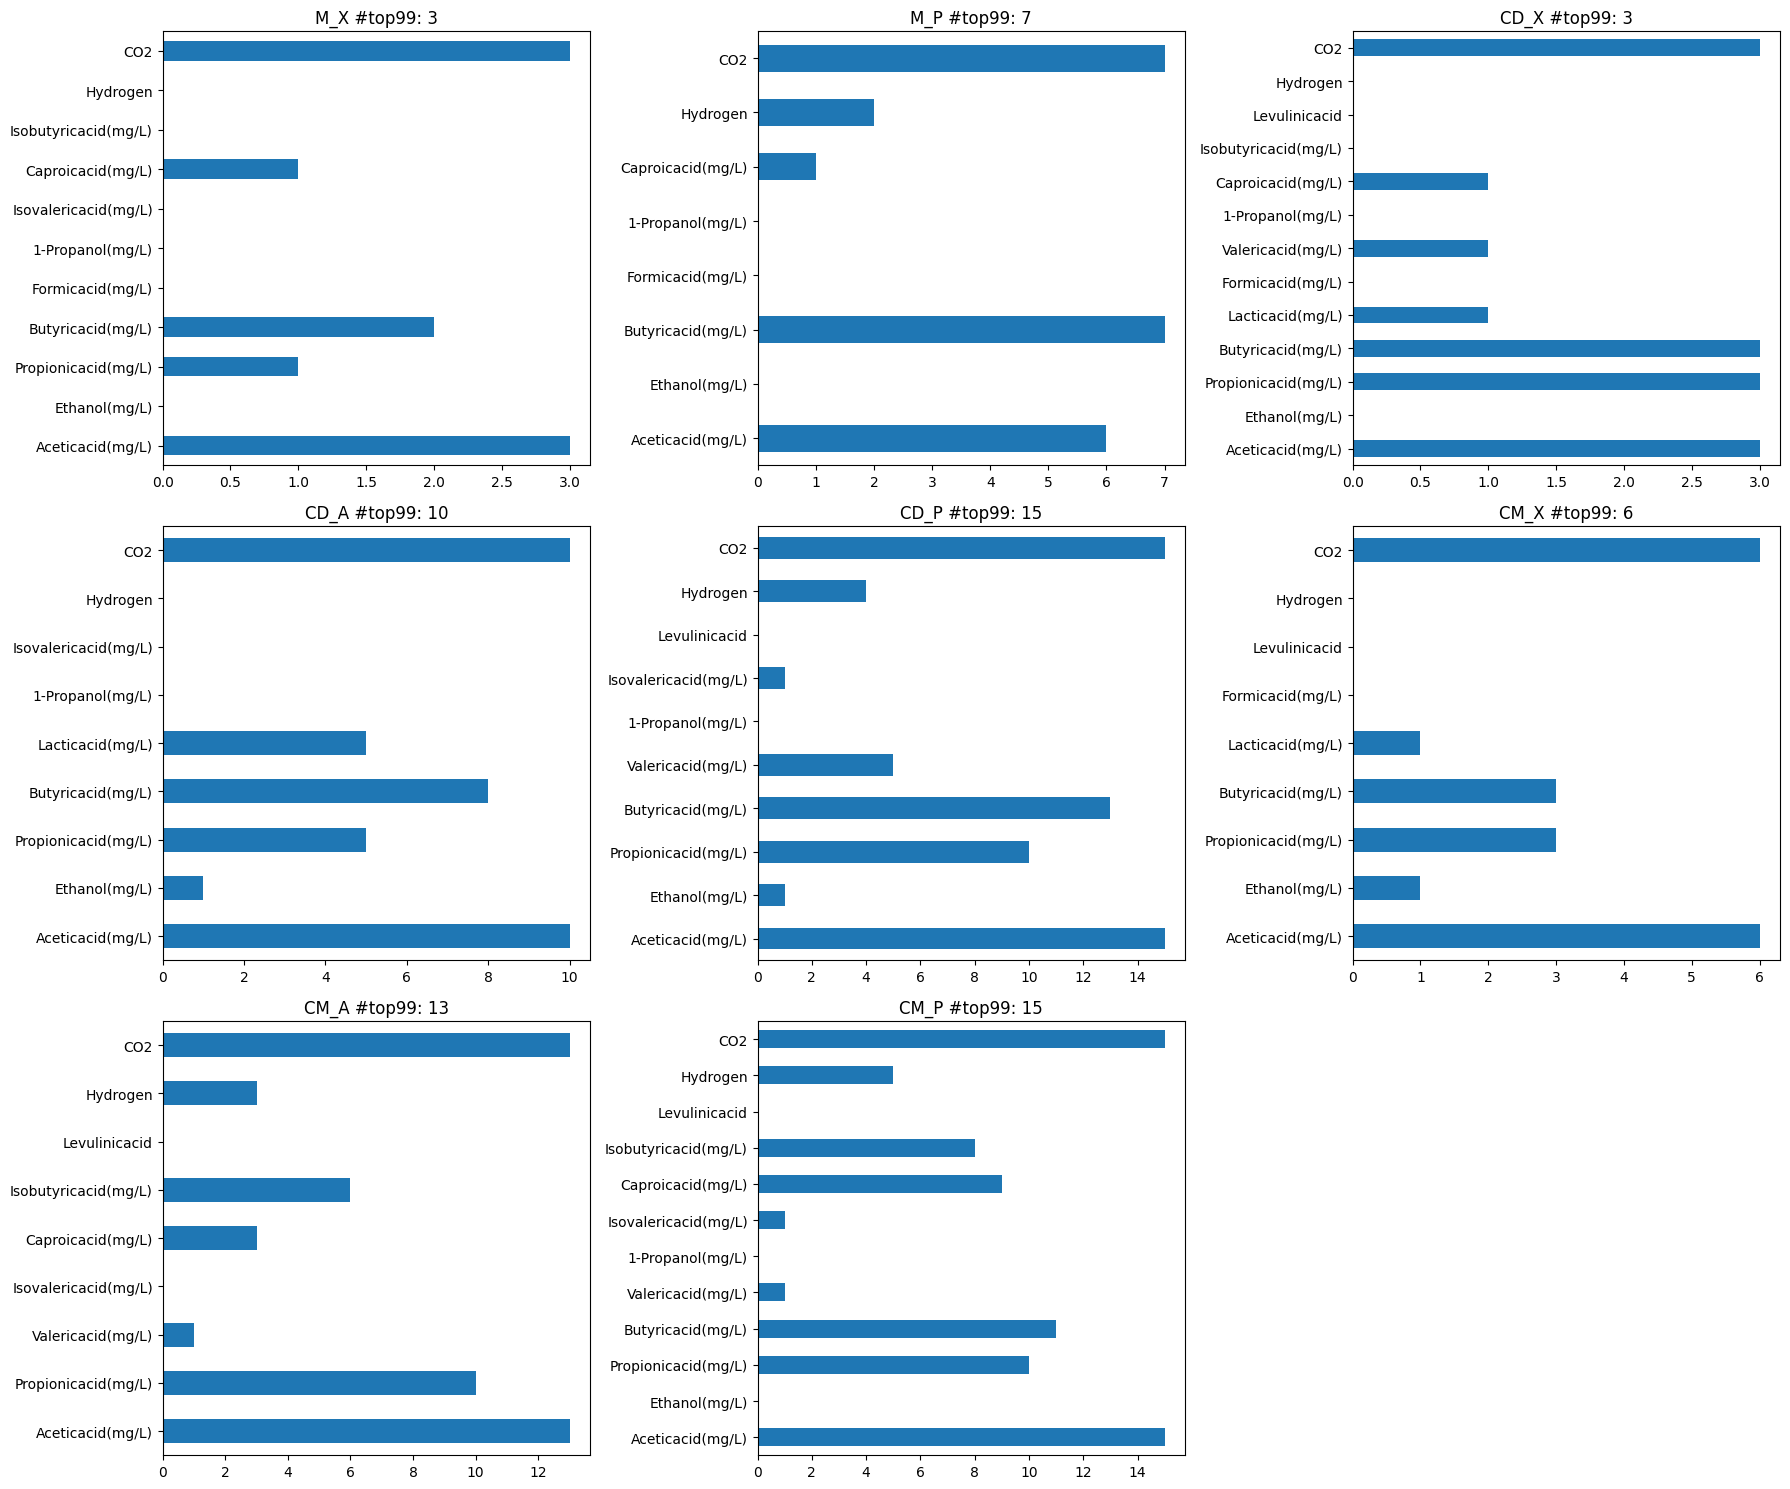

In [72]:
rows = math.ceil(len(dfs_community_count_top.keys())/3)

fig, axs = plt.subplots(rows,3, figsize=(18,5*rows))

i = 0

for community_id,df in dfs_community_count_top.items():

    df.plot(kind="barh", ax=axs[math.floor(i/3)][i%3])
    axs[math.floor(i/3)][i%3].title.set_text(community_id+" #top99: "+str(len(comm_producers_top[community_id].keys())))
    i = i+1
    
axs[2,2].set_axis_off()
fig.tight_layout()

### Define soft constraints

In [73]:
soft_constraints_new = {}

for community_id,producers_df in dfs_community_count_top.items():
    # Find compounds not produced
    not_produced = producers_df[producers_df==0].index
    
    soft_constraints_new[community_id]={}
    
    for compound in not_produced:
        soft_constraints_new[community_id]["R_EX_"+compounds_dict[compound]+"_e"]=1

### Media for gapfilling

We know that some of these compounds are produced when a specific electron donor is present. 

In [74]:
media_db = pd.read_csv("https://raw.githubusercontent.com/cdanielmachado/carveme/master/carveme/data/input/media_db.tsv",sep="\t")
media_db

,medium,description,compound,name
0,LB,Lysogeny broth,adn,Adenosine
1,LB,Lysogeny broth,ala__L,L-Alanine
2,LB,Lysogeny broth,amp,AMP
3,LB,Lysogeny broth,arg__L,L-Arginine
4,LB,Lysogeny broth,aso3,Arsenite
...,...,...,...,...
183,M9[glyc],M9 minimal medium (glycerol),ni2,Ni2+
184,M9[glyc],M9 minimal medium (glycerol),o2,O2
185,M9[glyc],M9 minimal medium (glycerol),pi,Phosphate
186,M9[glyc],M9 minimal medium (glycerol),so4,Sulfate


In [75]:
lb_02 = media_db[media_db.medium=="LB[-O2]"].copy()


lb_02.medium = lb_02.medium.map(lambda x:x.replace("LB[-O2]","LB_extend"))


lb_02.loc[-1] = ["LB_extend", "Additional elements for MCCA production", "lac__L","L-Lactate"] 
lb_02.loc[-1] = ["LB_extend", "Additional elements for MCCA production", "etoh","Ethanol"] 
lb_02.loc[-1] = ["LB_extend", "Additional elements for MCCA production", "ac","Acetate"] 
lb_02.loc[-1] = ["LB_extend", "Additional elements for MCCA production", "ppa","Propionate (n-C3:0)"] 
lb_02.loc[-1] = ["LB_extend", "Additional elements for MCCA production", "xyl__D","D-Xylose"] 
lb_02.loc[-1] = ["LB_extend", "Additional elements for MCCA production", "lcts","Lactose"] 

lb_02.reset_index(drop=True,inplace=True)
lb_02

,medium,description,compound,name
0,LB_extend,Lysogeny broth (anaerobic),adn,Adenosine
1,LB_extend,Lysogeny broth (anaerobic),ala__L,L-Alanine
2,LB_extend,Lysogeny broth (anaerobic),amp,AMP
3,LB_extend,Lysogeny broth (anaerobic),arg__L,L-Arginine
4,LB_extend,Lysogeny broth (anaerobic),aso3,Arsenite
...,...,...,...,...
60,LB_extend,Lysogeny broth (anaerobic),ura,Uracil
61,LB_extend,Lysogeny broth (anaerobic),uri,Uridine
62,LB_extend,Lysogeny broth (anaerobic),val__L,L-Valine
63,LB_extend,Lysogeny broth (anaerobic),zn2,Zn2+


### Save data

In [76]:
for community_id, dict_ in soft_constraints_new.items():
    pd.DataFrame(pd.Series(dict_)).to_csv("../output/soft_constraints/SC_"+community_id+".tsv",
                                          sep="\t",
                                          header=False,
                                          index_label=False)

In [77]:
lb_02.to_csv("../output/soft_constraints/SC_media_db.tsv",
                                         sep="\t",
                                         index_label=False)